In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# Making a list of calibration images
objpoints=[]
imgpoints=[]
images=glob.glob('C://Users//Shivam.Chawla01//CarND-Advanced-Lane-Lines//camera_cal//calibration*.jpg')
for fname in images:
    img=mpimg.imread(fname)

    #plt.imshow(img)
    
    

    objp=np.zeros((9*6,3),np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if(ret==True):
        imgpoints.append(corners)
        objpoints.append(objp)
        # draw chessboard corners
        img=cv2.drawChessboardCorners(img,(9,6),corners,ret)
        plt.imshow(img)
        






In [2]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Apply threshold
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if(orient=='x'):
        sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0)
        abs_sobel=np.absolute(sobelx)
    elif(orient=='y'):
        sobely=cv2.Sobel(gray,cv2.CV_64F,0,1)
        abs_sobel=np.absolute(sobely)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sxbinary=np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])]=1
    grad_binary=sxbinary
    return grad_binary

In [3]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobel_x=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_Sobel_x=np.absolute(sobel_x)
    abs_Sobel_y=np.absolute(sobel_y)
    grad_drtn=np.arctan2(abs_Sobel_y,abs_Sobel_x)
    binary_output=np.zeros_like(grad_drtn)
    binary_output[(grad_drtn>=thresh[0]) & (grad_drtn<=thresh[1])]=1
    return binary_output

In [4]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x=cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobel_y=cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Calculate the magnitude
    mag_sobel=np.sqrt(sobel_x**2+sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel=np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary=np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])]=1
    mag_binary=sxbinary
    return mag_binary
    

In [5]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S=hls[:,:,2]
    binary_output=np.zeros_like(S)
    # 3) Return a binary image of threshold result
    binary_output[(S>thresh[0]) & (S<=thresh[1])]=1
    #binary_output = np.copy(img) # placeholder line
    return binary_output

In [6]:
# for calibration of camera
def cal_undistort(img, objpoints, imgpoints):
        # Use cv2.calibrateCamera() and cv2.undistort()
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        udst=cv2.undistort(img,mtx,dist,None,mtx)
        
        return udst


In [20]:
globvar=[[]]

def pipeline(img):
    
    height=img.shape[0]
    width=img.shape[1]
    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    undistorted_mask=undistorted
    region_mask=np.zeros_like(undistorted_mask)
    area_of_interest=np.array([[0,height-1],[560,430],[664,430],[1359,height-1]],dtype=np.int32)
    region_mask=cv2.fillPoly(region_mask,[area_of_interest],(255,255,255))
    undistorted_mask=np.bitwise_and(undistorted,region_mask)
    
    #plt.imshow(undistorted_mask)
    
    img_size=(img.shape[1],img.shape[0])
    hls_threshold=hls_select(undistorted, (130, 150))
#     plt.imshow(hls_threshold)
    gradx = abs_sobel_thresh(undistorted, orient='x', thresh=(50, 100))
    #plt.imshow(gradx)
    #mag_threshold=mag_thresh(undistorted,3,(90, 255))
    dir_thresh=dir_threshold(undistorted,3,(0.7, 1.3))
    region_mask=cv2.cvtColor(region_mask,cv2.COLOR_RGB2GRAY)
    gradx=np.bitwise_and(gradx,region_mask)
    dir_thresh=dir_thresh.astype(np.int64)
    dir_thresh=np.bitwise_and(dir_thresh,region_mask)
    
    hls_threshold=np.bitwise_and(hls_threshold,region_mask)
    #dir_thresh=np.bitwise_and(dir_thresh,region_mask)
    
    combined_binary = np.zeros_like(gradx)
    combined_binary[(hls_threshold == 1) | (gradx == 1) | (dir_thresh==1)] = 1
  
    combined_binary=np.bitwise_and(combined_binary,region_mask)
    
    

    ksize=3
    src=np.float32([[526,503],[801,503],[884,549],[461,549]])
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst=np.float32([[200,300],[900,300],[900,500],[200,500]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M=cv2.getPerspectiveTransform(src,dst)
    warped=cv2.warpPerspective(combined_binary ,M,img_size,flags=cv2.INTER_LINEAR)
    #plt.imshow(warped,cmap='gray')
    combined=np.dstack((warped,warped,warped))*255
    out_img=combined
    global globvar
    
    warped_gray=cv2.cvtColor(combined,cv2.COLOR_RGB2GRAY)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
    histogram = np.sum(warped_gray[warped_gray.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
# Create an output image to draw on and  visualize the result
#out_img = np.dstack((combined, combined, combined))*255
    
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
# Choose the number of sliding windows
    nwindows = 9
# Set height of windows
    window_height = np.int(combined.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image

    
    
    
    
    
    
    
    
    
    
    nonzero = combined.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
# Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50
# Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
# Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = combined.shape[0] - (window+1)*window_height
        win_y_high = combined.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
            

    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    
    #right_lane_inds=np.mean(globvar,axis=0)
    #print(right_lane_inds.shape)
# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
    
    left_fit = np.polyfit(lefty, leftx, 2)

    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    
    
    
    
    
    
    
    
    nonzero = out_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    globvar.append(right_fit)
    
    if(len(globvar)>10):
        globvar=globvar[1:]
        
        right_fit=np.mean(np.array(globvar),axis=0)
    
# Generate x and y values for plotting
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    margin=((left_fitx+right_fitx)/2)

    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_gray, warped_gray, warped_gray))*255
    window_img = np.zeros_like(out_img)
# Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
    #print(np.int_([left_line_pts]))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    M=cv2.getPerspectiveTransform(dst,src)
    warped_orig=cv2.warpPerspective(window_img ,M,img_size,flags=cv2.INTER_LINEAR)
    
    y_eval = np.max(ploty)
    ploty = np.linspace(0, 719, num=720)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    curve_m=(left_curverad+right_curverad)/2
    
    lane_center=(left_fitx[img.shape[0]-1]+right_fitx[img.shape[0]-1])/2
    xm_per_pix = 3.7/700
    offset_pixels=(img.shape[0]/2-lane_center)
    offset_mtrs=xm_per_pix*offset_pixels
    
    

   
    result = cv2.addWeighted(undistorted, 1, warped_orig, 0.3, 0)
    result=cv2.putText(result,"curvature in mtrs: "+str(curve_m),(10,100),cv2.FONT_ITALIC,2,(10,20,180),2)
    result=cv2.putText(result,"Offset in mtrs: "+str(offset_mtrs),(10,200),cv2.FONT_ITALIC,2,(10,20,180),2)
    
    return result




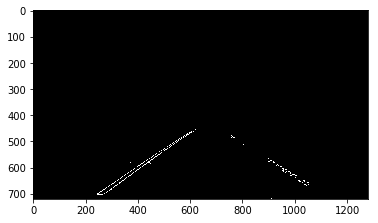

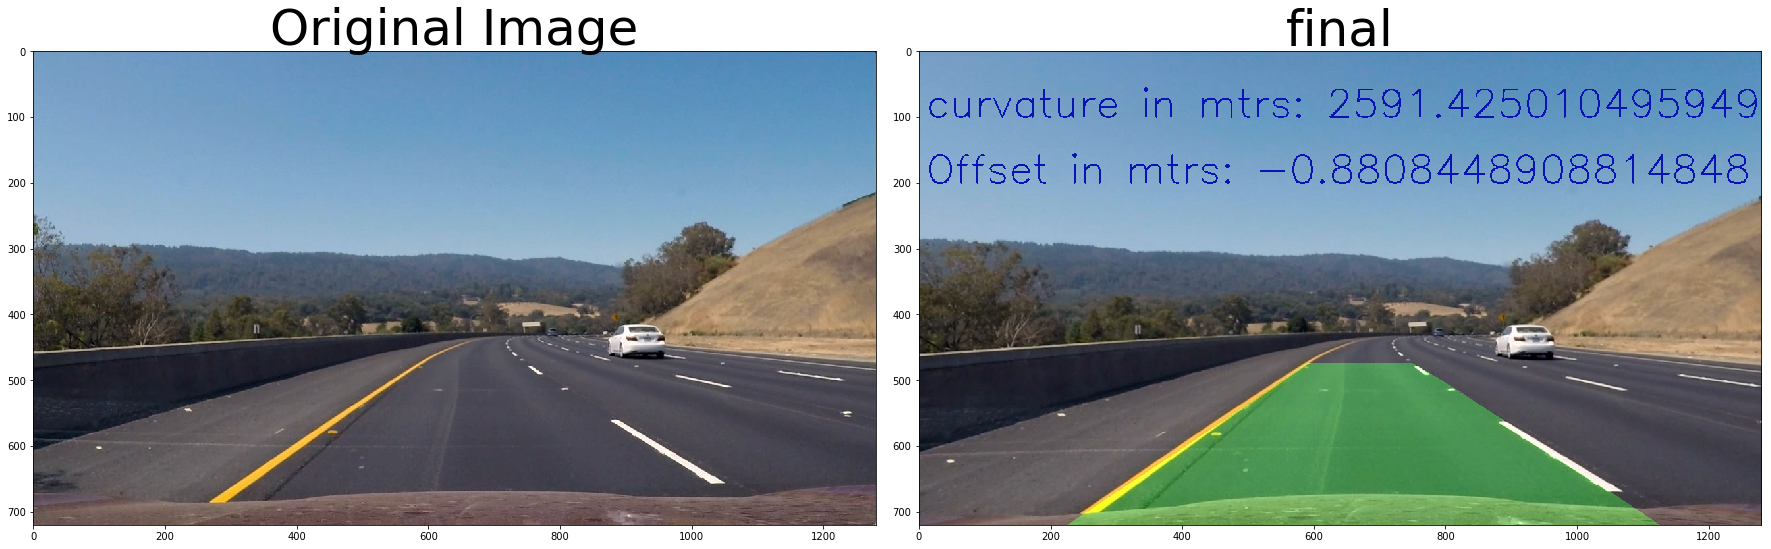

In [21]:
image = 'C://Users//Shivam.Chawla01//CarND-Advanced-Lane-Lines//test_images//test3.jpg'

img=mpimg.imread(image)
img_size=(img.shape[1],img.shape[0])

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image


combined=pipeline(img)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('final', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(1,10)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [27:45<00:01,  1.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 27min 46s
